# MUSIC for DOA

In [1]:
import os
%cd ".."
%pip install -e .

c:\Users\User\Documents\GitHub\uni\music-for-doa
Obtaining file:///C:/Users/User/Documents/GitHub/uni/music-for-doa
  Attempting uninstall: mfdoa
    Found existing installation: mfdoa 0.1
    Uninstalling mfdoa-0.1:
      Successfully uninstalled mfdoa-0.1
  Running setup.py develop for mfdoa
Note: you may need to restart the kernel to use updated packages.


In [2]:
from mfdoa.doa_estimators import DoaEstimatorMusic, DoaEstimatorMusicImproved, DoaEvaluator,DoaEstimatorMusic2Dmics,DoaEstimatorPryoomacousticsMUSIC
from mfdoa.generator import Generator
from mfdoa.visualizor import plot_music_doa_estimation
from mfdoa.utils import utils

import numpy as np
import matplotlib.pyplot as plt
import os

import pyroomacoustics as pra

import json
from scipy.io import wavfile

%reload_ext autoreload
%autoreload 2


## Examples for DOA estimation
### Using generation.json config file

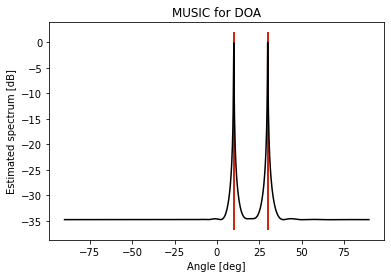

Predicted angles: ['10.00', '30.00']
Ground truth angles: [10, 30]
MAE: 1.563e-12 deg
MAX SNR: 34.79 dB


In [3]:
# Use config file for data generation.
gen = Generator()
data = gen.generate()
doamusic = DoaEstimatorMusicImproved(gen)
doamusic.num_sources = 2
Pmusic, pred_angles = doamusic.get_doa_estimate(data)
Pmusic = utils.get_log_power_values(Pmusic)

SAVE_NAME = None #"a2_music_improv_cor.png"
# plot
plot_music_doa_estimation(gen.doas_deg, doamusic.theta, pred_angles, Pmusic, save_name=SAVE_NAME)
print(f"Predicted angles:",[f"{angle:.2F}" for angle in pred_angles])
print(f"Ground truth angles: {gen.doas_deg}")
mae = DoaEvaluator.get_mae(pred_angles, gen.doas_deg)
print(f"MAE: {mae:.4} deg")
max_snr = DoaEvaluator.get_max_SNR(Pmusic)
print(f"MAX SNR: {max_snr:.4} dB")


## Get real data

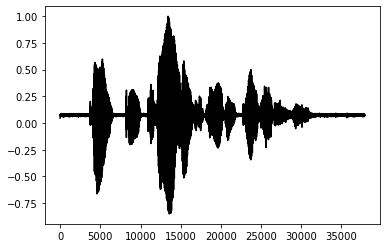

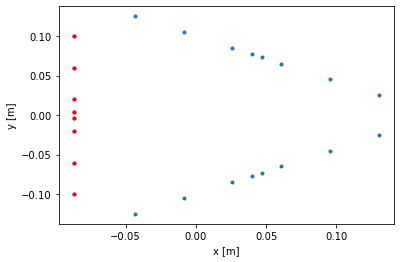

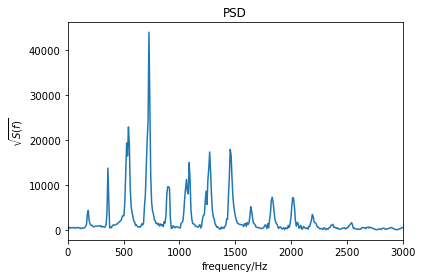

f=728.0
(8, 2000)


In [4]:
ANGLE = 20
rate, raw_data = wavfile.read(f"data/fq_sample3_spkr0_angle{ANGLE}.wav")
intv = np.arange(13_000, 15_000)
fs = 16000

t = np.linspace(0,1/fs,raw_data.shape[0])*1e6
plt.plot(raw_data[:,0]/max(raw_data[:,0]),'k')

plt.figure()

with open('data/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

# Get top mics
dataslice = raw_data[intv, :]
array = np.arange(48)[top_mics]
side1 = array[:8] # take 8 microphones which are in a line -> same as in sim
real_data = dataslice[:,side1].T

mics_in_one_line = microphone_2D_locations[:8]

plt.plot(microphone_2D_locations[:,0],microphone_2D_locations[:,1],'.')
plt.plot(mics_in_one_line[:,0],mics_in_one_line[:,1],'r.')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

arrayid = np.arange(48)[top_mics]
side1 = arrayid[:8]

# -----

Xw = np.fft.fft(raw_data[intv, :] - np.mean(raw_data[intv,:],axis=0),axis=0)

L = np.size(Xw[:,0])/2
freqs = np.arange(0, fs/2, fs/2/L)
plt.plot(freqs, np.abs(Xw[:int(L),0]))
# plt.plot(freqs, np.abs(Xw[:int(L),3]))
plt.xlabel('frequency/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.title('PSD')
plt.xlim([0,3000])
plt.show()

# -----
f = freqs[np.argmax(np.abs(Xw[:int(L)]),axis=0)][0]
print(f"f={f}")

###
print(real_data.shape)

## DOA Estimation with custom implementation

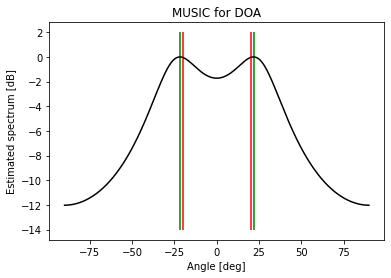

Predicted angles: [-21.8  21.8]
Ground truth angles: [-20  20]
MAE: 1.8 deg
MAX SNR: 12.022314446686778 dB


In [5]:
real_data = raw_data[:,side1].T

doamusic_real = DoaEstimatorMusic()
# doamusic_real.pos_micros = np.array([0, 0.04, 0.08, 0.098, 0.102, 0.12, 0.16, 0.2])
doamusic_real.pos_micros = mics_in_one_line[:,1] -np.min(mics_in_one_line[:,1])
doamusic_real.wavelen = 343 / f
doamusic_real.n_micros = len(doamusic_real.pos_micros)
doamusic_real.num_sources = 2

Pmusic, pred_angles = doamusic_real.get_doa_estimate(real_data)
Pmusic = utils.get_log_power_values(Pmusic)

gt_angles = np.array([-ANGLE, ANGLE])
plot_music_doa_estimation(gt_angles, doamusic_real.theta, pred_angles, Pmusic) #, save_name="music_real.png")
print(f"Predicted angles: {np.round(pred_angles,2)}\nGround truth angles: {gt_angles}")
mae = DoaEvaluator.get_mae(pred_angles, gt_angles)
print(f"MAE: {mae:.4} deg")
max_snr = DoaEvaluator.get_max_SNR(Pmusic)
print(f"MAX SNR: {max_snr} dB")

## DOA estimation with pyroom accoustics library

c:\Users\User\anaconda3\lib\site-packages\numpy\ma\core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


MUSIC Estimate: [18.].


c:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 0, 'f [kHz]')

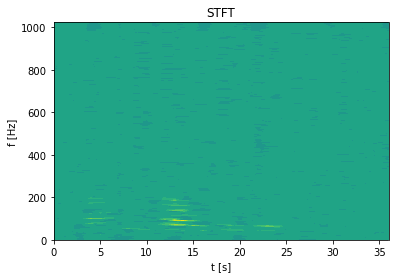

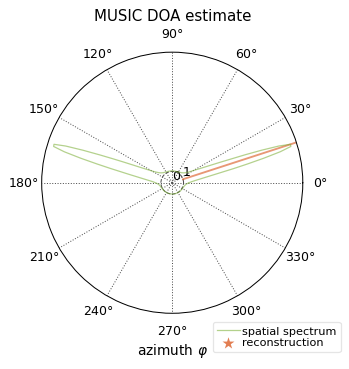

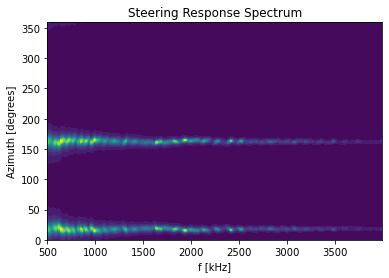

In [6]:
real_data = raw_data[:,side1].T

nfft = 2048
_stft = pra.transform.stft.STFT(nfft,hop=nfft//2,transform=np.fft.rfft)
spec = np.array([_stft.analysis(real_data.T[:,i]).T for i in range(real_data.T.shape[1])])
plt.contourf(spec[3,:,:], 20)
plt.ylabel("f [Hz]")
plt.xlabel("t [s]")
plt.title("STFT")

R = microphone_2D_locations.T[:,:8]
doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate,pos_micros=R,num_src=1, nfft=nfft)
doa_music.get_doa_estimate(real_data.T)
doa_music.plot_doa_estimate('MUSIC')
plt.title("MUSIC DOA estimate")

plt.figure()
(pseudo_spectrum, freqs, azimuth, est_doa) = doa_music.return_doa_estimates()
X,Y = np.meshgrid(freqs,azimuth)
Z = pseudo_spectrum
plt.contourf(X, Y, Z, 20)
plt.title(f"Steering Response Spectrum")
plt.ylabel('Azimuth [degrees]')
plt.xlabel('f [kHz]')

## Multi Source Data

### Getting real data and selecting a specific time slot

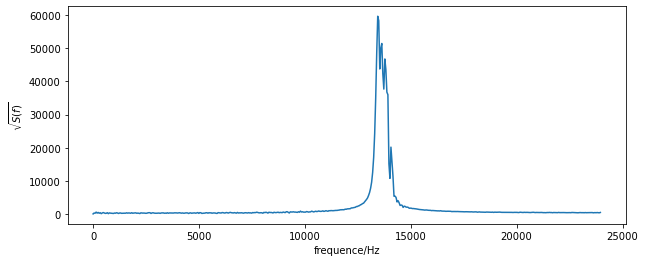

13440.0 13632.0
[280 720] [284 716]


In [7]:
import math

true_angle = {"speechco":[42, 350, 222, 170], 
              "speechun":[8, 60, 188, 240], 
              "sweepco": [32, 66, 212, 246],
              "sweepun": [120, 150, 300, 330]}
true_angle_for_side = {0: {"speechco":[42, 10, -42, -10], 
                           "speechun":[8, 60, -8, -60], 
                           "sweepco": [32, 66, -32, -66],
                           "sweepun": [60, 30, -60, -30]},
                       1: {"speechco":[78, -78, 50, -50], 
                           "speechun":[68, -68, 30, -30], 
                           "sweepco": [88, -88, 24, -24],
                           "sweepun": [0, 30, -30]},
                       2: {"speechco":[18, -18, -70, 70], 
                           "speechun":[52, -52, 0], 
                           "sweepco": [28, -28, 6, -6],
                           "sweepun": [60, -60, 90, -90]}}

# three-sides detection
rate, raw_data = wavfile.read('data/sweep_correlated.wav')

intv = np.arange(11000, 12000)
dataslice = raw_data[intv, :]

# plt.plot(raw_data)
# plt.figure()
# plt.plot(dataslice)

N = np.size(intv)
L = N/2
plt.figure(figsize=(10,4))

fs = rate
Xw = np.fft.fft(raw_data[intv, 0] - np.mean(raw_data[intv, 0]))
freqs = np.arange(0, fs/2, fs/2/L)
plt.plot(freqs, np.abs(Xw[:int(L)]))
plt.xlabel('frequence/Hz')
plt.ylabel('$\sqrt{S(f)}$')
plt.show()

# M=2 only for sweep
f_peaks = freqs[utils.get_m_largest_peaks(np.abs(Xw[:int(L)]),M = 2)] 

f1,f2 = f_peaks
print(f1,f2)

arg1 = np.array([math.floor(f1/fs*1000), math.floor((fs-f1)/fs*1000)])
arg2 = np.array([math.floor(f2/fs*1000), math.floor((fs-f2)/fs*1000)])
print(arg1,arg2)

# Cutting out the amplitude of the 2 specific frequency values for each microphone
s_f_1 = np.zeros((N, dataslice.shape[1]), dtype=complex)
s_f_2 = np.zeros((N, dataslice.shape[1]), dtype=complex)
S1 = np.zeros(N, dtype=complex)
S2 = np.zeros(N, dtype=complex)

S = np.fft.fft(dataslice,axis=0)
for j in range(dataslice.shape[1]):
    S1[arg1] = S[arg1,j]
    S2[arg2] = S[arg2,j]
    s_f_1[:, j] = np.fft.ifft(S1)
    s_f_2[:, j] = np.fft.ifft(S2)

### DOA estimation with improved MUSIC

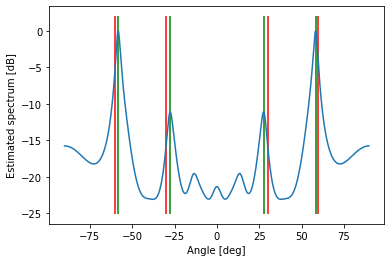

In [8]:
doamusic_real = DoaEstimatorMusicImproved()
doamusic_real.pos_micros = mics_in_one_line[:,1] -np.min(mics_in_one_line[:,1])
doamusic_real.wavelen = 343 / f
doamusic_real.n_micros = len(doamusic_real.pos_micros)
doamusic_real.num_sources = 4

# plt.figure(figsize=(12,8))

# Go through all linear setups
for i in range(1): #3
    X1 = s_f_1[:, 8*i:8*(i+1)].T
    X2 = s_f_2[:, 8*i:8*(i+1)].T
    
    doamusic_real.wavelen = 343 / f1

    Pmusic, pred_angles = doamusic_real.get_doa_estimate(X1)
    Pmusic = utils.get_log_power_values(Pmusic)

    plt.plot(doamusic_real.theta, Pmusic)
    for angle in true_angle_for_side[i]["sweepun"]:
        plt.vlines(angle, Pmusic.min() - 2, Pmusic.max() + 2, "r")
    plt.vlines(pred_angles, Pmusic.min() - 2, Pmusic.max() + 2, "g")
    plt.xlabel("Angle [deg]")
    plt.ylabel("Estimated spectrum [dB]")

# SAVE_NAME = "a2_real_uncor_music.png"
# plt.savefig("figures/" + SAVE_NAME)

plt.show()

# ---------------------------------------------

## Using pyroomacoustics Library to compare advanced methods

In [9]:
import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [10]:
indices=np.arange(len(top_mics))[top_mics]
print(indices)

[ 8  9 10 11 12 13 14 15 24 25 26 27 28 29 30 31 40 41 42 43 44 45 46 47]


## GUI demonstration with manipulated real data and using several methods

In [12]:
from mfdoa.doa_estimators import DoaEstimatorPryoomacousticsMUSIC, DoaEstimatorPryoomacousticsFRIDA,DoaEstimatorPryoomacousticsSRP
import time
from ipywidgets import interact_manual, widgets


rate1, data1 = wavfile.read('data/fq_sample3_spkr0_angle20.wav')
rate2, data2 = wavfile.read('data/fq_sample3_spkr0_angle70.wav')

R=microphone_2D_locations.T
gt = np.radians([20, 70])


def demonstrate_doa_real_data(circshift_sec, nfft, snr_injected):

    global data1, data2, R, gt

    nfft = int(nfft)

    circshift = int(circshift_sec * rate1)

    data = data1[:,indices]+np.roll(data2, circshift, axis=0)[:,indices]

    power = np.sum(data**2) / sum(data.shape)
    sigma = np.sqrt(power * 10**(-snr_injected/10))
    # print('-',power, sigma, np.max(data),np.max(sigma * np.random.randn(data.shape[0],data.shape[1])))

    data = data.astype(np.float64) + sigma * np.random.randn(data.shape[0],data.shape[1])

    nfft = nfft
    num_src = 2

    tic = time.perf_counter()
    doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate1,pos_micros=R,num_src=num_src, nfft=nfft)
    doa_music.get_doa_estimate(data)
    doa_music.plot_steering_response_spectra("MUSIC Steering Response Spectrum")
    plt.figure()
    doa_music.plot_doa_estimate("MUSIC", gt)
    toc = time.perf_counter()
    print(f"MUSIC needed {toc-tic:.4f}s.")

    tic = time.perf_counter()
    doa = DoaEstimatorPryoomacousticsFRIDA(sampling_frequency=rate1,pos_micros=R,num_src=num_src, nfft=nfft)
    doa.get_doa_estimate(data)
    doa.plot_doa_estimate("FRIDA", gt)
    toc = time.perf_counter()
    print(f"FRIDA needed {toc-tic:.4f}s.")

    tic = time.perf_counter()
    doa = DoaEstimatorPryoomacousticsSRP(sampling_frequency=rate1,pos_micros=R,num_src=num_src, nfft=nfft)
    doa.get_doa_estimate(data)
    doa.plot_doa_estimate("SRP", gt)
    toc = time.perf_counter()
    print(f"SRP needed {toc-tic:.4f}s.")

my_interact_manual = interact_manual.options(manual_name="Update plot.")
my_interact_manual(demonstrate_doa_real_data,  \
     circshift_sec=#widgets.FloatSlider(min=0., max=0.3, step=0.0001, value=0.1, description="circshift [s]"), \
        widgets.FloatLogSlider(
        value=0.1,
        base=10,
        min=-6, # max exponent of base
        max=0, # min exponent of base
        step=1, # exponent step
        description='circshift'),
     nfft=widgets.FloatLogSlider(
        value=128,
        base=2,
        min=6, # max exponent of base
        max=13, # min exponent of base
        step=1, # exponent step
        description='NFFT'),
    snr_injected=widgets.IntSlider(min=-5, max=10, step=1, value=2, description="Noise inj (SNR in dB)"), \
    );

interactive(children=(FloatLogSlider(value=0.1, description='circshift', max=0.0, min=-6.0, step=1.0), FloatLo…

## Computation of MAE for different mehods

In [ ]:
# Sweep
rate1, data1 = wavfile.read('data/fq_sample3_spkr0_angle20.wav')
rate2, data2 = wavfile.read('data/fq_sample3_spkr0_angle70.wav')

R=microphone_2D_locations.T
gt = np.radians([20, 70])

num_c, num_snr = 11, 9

res_s = dict()
res_s["music"] = np.zeros((num_c,num_snr))
res_s["frida"] = np.zeros((num_c,num_snr))
res_s["srp"] = np.zeros((num_c,num_snr))

shifts_s = np.linspace(0,0.05,num=num_c) #np.logspace(0,6,num=num_snr,base=10)
# snr_s = np.logspace(0,4,num=num_snr,base=10)
snr_s = np.linspace(-4,4,num=num_snr)

def compute_doa_real_data(circshift_sec, nfft, snr_injected):

    global data1, data2, R, gt, res_s

    nfft = int(nfft)

    circshift = int(circshift_sec * rate1)

    data = data1[:,indices]+np.roll(data2, circshift, axis=0)[:,indices]

    power = np.sum(data**2) / sum(data.shape)
    sigma = np.sqrt(power * 10**(-snr_injected/10))

    data = data.astype(np.float64) + sigma * np.random.randn(data.shape[0],data.shape[1])

    nfft = nfft
    num_src = 2

    doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate1,pos_micros=R,num_src=num_src, nfft=nfft)
    doa_music.get_doa_estimate(data)
    mae_music = doa_music.get_mae(gt)

    doa = DoaEstimatorPryoomacousticsFRIDA(sampling_frequency=rate1,pos_micros=R,num_src=num_src, nfft=nfft)
    doa.get_doa_estimate(data)
    mae_frida = doa.get_mae(gt)

    doa = DoaEstimatorPryoomacousticsSRP(sampling_frequency=rate1,pos_micros=R,num_src=num_src, nfft=nfft)
    doa.get_doa_estimate(data)
    mae_srp = doa.get_mae(gt)

    return mae_music, mae_frida, mae_srp


for ic_, cs in enumerate(shifts_s):
    for is_, snr_j in enumerate(snr_s):
        for i in range(5):
            mae_music, mae_frida, mae_srp = compute_doa_real_data(cs,256,snr_j)
            res_s["music"][ic_,is_] += mae_music/5
            res_s["frida"][ic_,is_] += mae_frida/5
            res_s["srp"][ic_,is_] += mae_srp/5

# for irs in res_s.keys():
#     res_s[irs] = np.array(res_s[irs]).reshape(num_c,7) # N_circshifts x N_snrs


### Plotting the results

Text(0, 0.5, 'MAE for 0.035s')

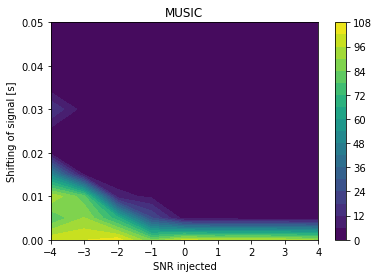

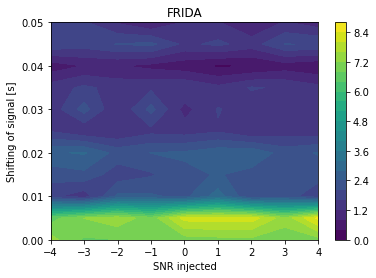

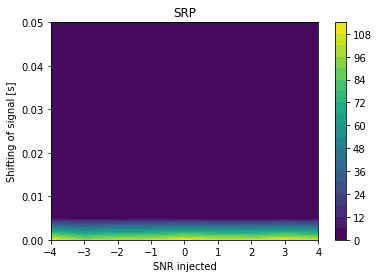

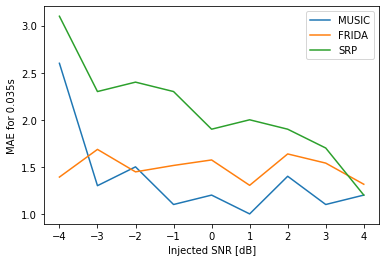

In [ ]:
from matplotlib import ticker, cm

X,Y = np.meshgrid(snr_s,shifts_s)
Z = res_s["music"]
plt.contourf(X, Y, Z, 20)#, locator=ticker.LogLocator())
plt.title("MUSIC")
plt.ylabel('Shifting of signal [s]')
plt.xlabel('SNR injected')
plt.colorbar()

plt.figure()
Z = res_s["frida"]
plt.contourf(X, Y, Z, 20)
plt.title("FRIDA")
plt.ylabel('Shifting of signal [s]')
plt.xlabel('SNR injected')
plt.colorbar()

plt.figure()
Z = res_s["srp"]
plt.contourf(X, Y, Z, 20)
plt.title("SRP")
plt.ylabel('Shifting of signal [s]')
plt.xlabel('SNR injected')
plt.colorbar()

plt.figure()
plt.plot(snr_s, res_s["music"][7,:])
plt.plot(snr_s, res_s["frida"][7,:])
plt.plot(snr_s, res_s["srp"][7,:])
# plt.ylim([0,10])
plt.legend(["MUSIC","FRIDA","SRP"])
plt.xlabel("Injected SNR [dB]")
plt.ylabel("MAE for 0.035s")

## Applying to 3D microphone

MUSIC Estimate: [69.].


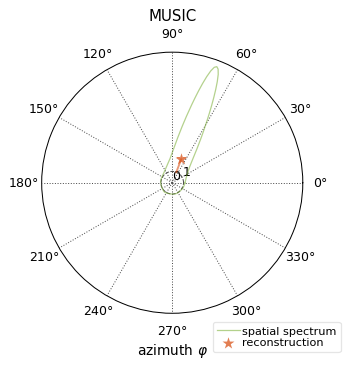

In [ ]:
R = microphone_3D_locations.T
rate1, data1 = wavfile.read('data/fq_sample3_spkr0_angle70.wav');
doa_music = DoaEstimatorPryoomacousticsMUSIC(sampling_frequency=rate1,pos_micros=R,num_src=1)
doa_music.get_doa_estimate(data1)
doa_music.plot_doa_estimate("MUSIC")